In [1]:
from samay.model import LPTMModel

config = {
    "task_name": "forecasting",
    "forecast_horizon": 192,
    "head_dropout": 0,
    "weight_decay": 0,
    "max_patch": 16,
    "freeze_encoder": True,  # Freeze the patch embedding layer
    "freeze_embedder": True,  # Freeze the transformer encoder
    "freeze_head": False,  # The linear forecasting head must be trained
    "freeze_segment": True,  # Freeze the segmention module
}
model = LPTMModel(config)

INFO:p-2231153:t-140160196347712:backbone.py:_validate_inputs:Setting d_model to 768
INFO:p-2231153:t-140160196347712:backbone.py:_get_transformer_backbone:Initializing pre-trained transformer from google/flan-t5-base.
INFO:p-2231153:t-140160196347712:backbone.py:_get_transformer_backbone:Enabling gradient checkpointing.


In [2]:
from samay.dataset import LPTMDataset

train_dataset = LPTMDataset(
    name="ett",
    datetime_col="date",
    path="../data/data/ETTh1.csv",
    mode="train",
    horizon=192,
)

finetuned_model = model.finetune(train_dataset)

/nethome/sanand315/Samay/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 0: Train loss: 0.637
Epoch 1: Train loss: 0.545
Epoch 2: Train loss: 0.518
Epoch 3: Train loss: 0.503
Epoch 4: Train loss: 0.492


In [3]:
val_dataset = LPTMDataset(
    name="ett",
    datetime_col="date",
    path="../data/data/ETTh1.csv",
    mode="train",
    horizon=192,
)
avg_loss, trues, preds, histories = model.evaluate(val_dataset, task_name="forecasting")
avg_loss

0.48269497615392093

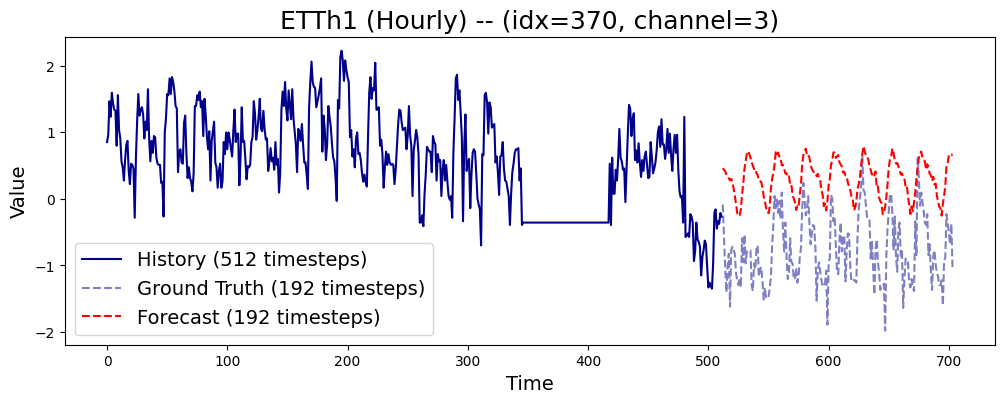

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random channel and time index
trues = np.array(trues)
preds = np.array(preds)
histories = np.array(histories)
channel_idx = np.random.randint(0, 7)
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label="History (512 timesteps)", c="darkblue")

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(
    range(offset, offset + len(true)),
    true,
    label="Ground Truth (192 timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + len(pred)),
    pred,
    label="Forecast (192 timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()